In [42]:
import sys
sys.path.insert(0, r'../../quetzal/')
from syspy.syspy_utils import neighbors

import pandas as pd 
import geopandas as gpd
ipath = r'../inputs/'
dpath = r'data/'

In [43]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 15)

In [44]:
# load basemaps
import rasterio
from rasterio import plot as _
raster_light = rasterio.open(dpath + r'raster_light.tiff')
raster_dark = rasterio.open(dpath + r'raster_dark.tiff')

# Read station data

Create station geodataframe

In [45]:
df = pd.read_csv(dpath + r'stations.csv')

In [46]:
from shapely.geometry import Point

In [47]:
def row_to_point(row):
    return Point([row['lon'], row['lat']])

In [48]:
df['geometry'] = df.apply(row_to_point, axis=1)

In [49]:
type(df)

pandas.core.frame.DataFrame

In [50]:
stations = gpd.GeoDataFrame(df)

In [51]:
type(stations)

geopandas.geodataframe.GeoDataFrame

In [52]:
stations.crs = {'init': 'epsg:4326'}

In [53]:
stations.head(1)

,Unnamed: 0,lat,lon,geometry
0,0,48.881178,2.283615,POINT (2.28361 48.88118)


In [54]:
stations = stations.to_crs(epsg=2154)

In [55]:
stations['capacity'] = 2

Exercice:
1. Créer un GeoDataFrame stations à partir de ce fichier
2. Définir son crs comme étant ```{'init': 'epsg:4326'}```
3. Le convertir en EPSG 2154
4. Rajouter une colonne `capacity`, valant 2

# Read vehicle data

Create vehicle geodataframe

In [56]:
vehicles = pd.read_csv(dpath + r'vehicles.csv', index_col=0).dropna()

In [57]:
def loc_to_point(loc):
    loc_list = loc.split(',')
    loc_list_float = [float(a) for a in loc_list]
    return Point([loc_list_float[1], loc_list_float[0]])

In [58]:
vehicles['geometry'] = vehicles['loc'].apply(loc_to_point)
vehicles = gpd.GeoDataFrame(vehicles)
vehicles.crs = {'init': 'epsg:4326'}
vehicles = vehicles.to_crs(epsg=2154)

Exercice:

- Idem que l'exercice précédent pour le fichier vehicles
- Filter ces véhicles en ne gardant que ceux contenu dans l'enveloppe convex des stations

## Controle

<AxesSubplot:>

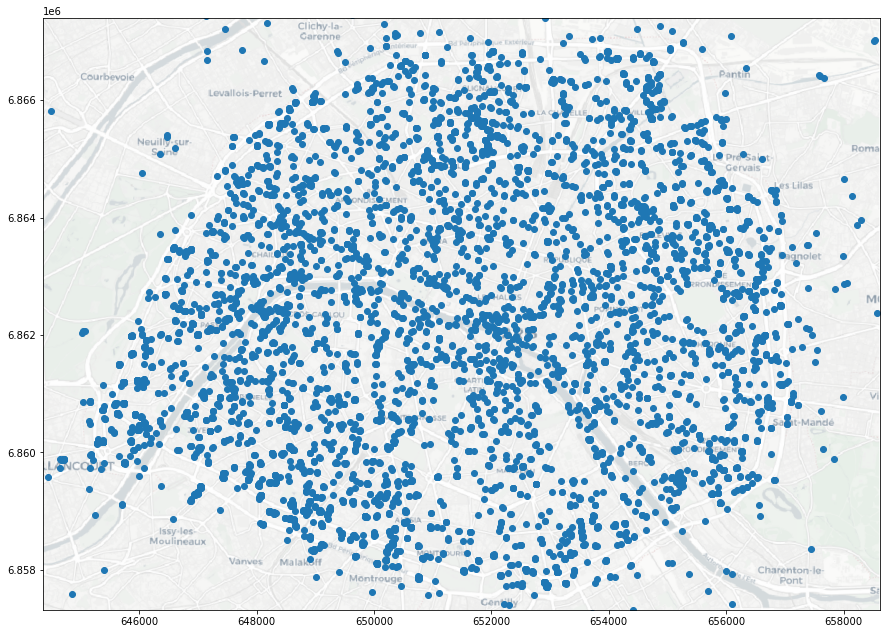

In [59]:
ax = vehicles.plot()
rasterio.plot.show(raster_light, ax=ax)

In [60]:
print(len(vehicles), len(stations))

7485 2446


# Assign each vehicle to the nearest station

# Compute the number of vehicle by station

Exercice

1. Créer une colonne `station_id` dans la table vehicles, indiquant l'ID de la station la plus proche
2. Calculer le nombre de vehicle par station
3. Ne garder que les stations avec moins de 100 véhicles

Indice: utiliser la méthode `neighbors.nearest`

In [61]:
vehicles['station_id'] = neighbors.nearest(vehicles, stations).set_index('ix_one')['ix_many']

In [68]:
stations['nb_vehicles'] = vehicles.groupby('station_id')['loc'].count()

In [71]:
stations.fillna(0, inplace=True)

In [73]:
stations = stations.loc[stations['nb_vehicles']<100]

# Saturation

Exercice
1. Rajouter une colonne `saturation` dans la table `stations`, calculant la ratio n_vehicle par capacity
2. Afficher une carte de cette saturation, en utilisant le fond de carte raster_dark

# Aggregate stations by clusters

Exercice

1. Créer des clusters de stations à partir de la méthode spatial.agglomerative_clustering
2. Créer un nouveau DataFrame `macro_stations` contenant une ligne par macro-stations, et une géométrie correspondant à l'enveloppe convexe des stations la composant
3. Calculer la capacité, le nombre de véhicules stationnés, et la saturation de chaque macro-station

<AxesSubplot:>

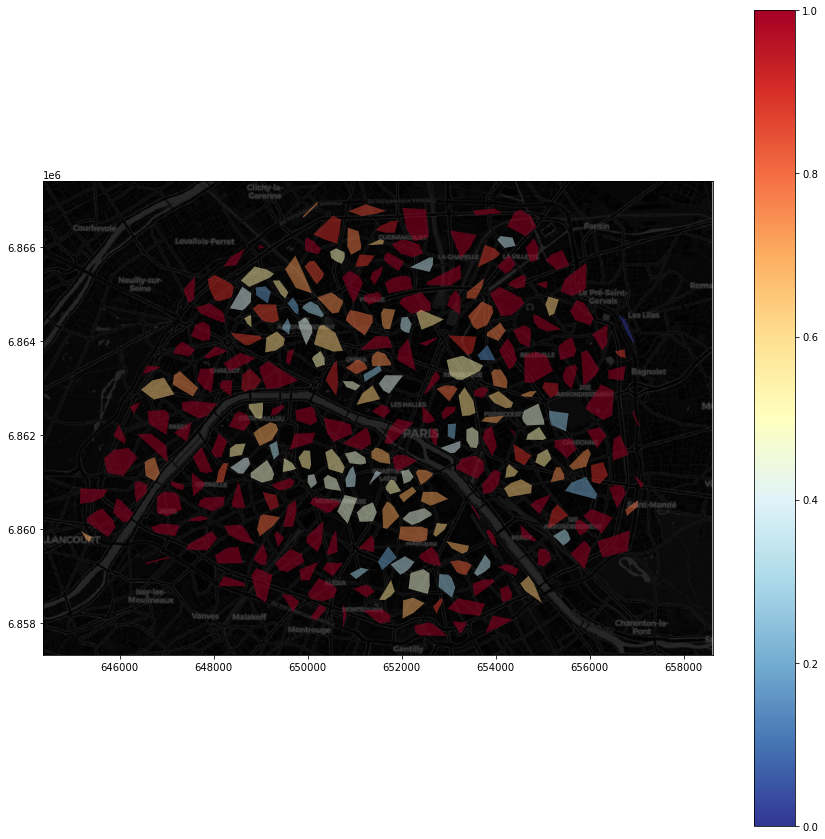

In [21]:
ax = macro_stations.plot('saturation', cmap='RdYlBu_r', legend=True, vmin=0, vmax=1, alpha=0.5)
rasterio.plot.show(raster_dark, ax=ax)